In [20]:
import os
import math
import random
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import notebook
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn

from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import transforms as T

from torch.utils.tensorboard import SummaryWriter
from efficientnet_pytorch import EfficientNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
class configs:
    IMAGE_SIZE = 224
    NUM_WORKERS = 2
    BATCH_SIZE = 32
    EPOCHS = 100
    SEED = 69
    CHECKPOINT = "./checkpoints/cnn_eff0_model/"
    MODEL_NAME = 'efficientnet-b0'
    scheduler_params = {
        "lr_start": 3e-5,
        "lr_max": 6e-5,
        "lr_min": 1e-6,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }

    model_params = {
    'model_name':MODEL_NAME,
    'in_channels':3,
    'image_size':IMAGE_SIZE,
    'num_classes':2,
    }

In [22]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(configs.SEED)

In [24]:
train_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=(0.8,1.2)),
    T.RandomAffine(degrees=(-10,10),translate =(0.1,0.1),shear =(-5,5,-5,5),interpolation = T.InterpolationMode.BILINEAR),
    T.RandomPerspective(distortion_scale=0.3),
    T.ToTensor(),
    T.RandomApply([T.Lambda(lambda x : x + (0.1**0.7)*torch.randn(3,configs.IMAGE_SIZE,configs.IMAGE_SIZE))],p=0.08),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [25]:
class FindItData(Dataset):
    def __init__(self,df,split,transform):
        self.img_locs = list(df.image)
        self.targets = list(df.forged)
        self.transform = transform
        self.split = split
    def  __len__(self):
        return len(self.targets)
    def __getitem__(self,idx):
        img_loc = str(self.img_locs[idx])
        img = cv2.imread("./"+self.split+"/"+img_loc)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        target = self.targets[idx]
        return img,target

In [26]:
df_train = pd.read_csv("train.txt")
df_test = pd.read_csv("test.txt")

In [27]:
df_train.head()

,image,digital annotation,handwritten annotation,forged,forgery annotations
0,X00016469622.png,1,1,1,"{'filename': 'X00016469622.png', 'size': 23072..."
1,X00016469623.png,1,1,0,0
2,X00016469670.png,1,1,0,0
3,X00016469671.png,1,1,0,0
4,X00016469672.png,1,1,0,0


In [28]:
img = cv2.imread("./train/"+df_train['image'][0])

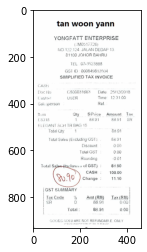

In [29]:
plt.imshow(img)

In [30]:
train_ds = FindItData(df_train,"train",train_trns)
train_loader = DataLoader(train_ds, batch_size=configs.BATCH_SIZE, shuffle=True, drop_last=True)
val_ds = FindItData(df_test,"test",val_trns)
val_loader = DataLoader(val_ds, batch_size=configs.BATCH_SIZE, shuffle=False, drop_last=True)


In [31]:
class CNNModel(nn.Module):
    def __init__(self,model_name='efficientnet-b0',in_channels=3,image_size=224,num_classes=35):
        super(CNNModel,self).__init__()
        self.model = EfficientNet.from_pretrained(model_name=model_name,in_channels=in_channels,image_size=image_size,num_classes=num_classes)

    def forward(self, images):
        return self.model(images)

In [32]:
labels_tensor = torch.tensor(df_train['forged'])
class_count = torch.bincount(labels_tensor)
total_samples = torch.sum(class_count)
class_frequencies = class_count.float()/total_samples

inverse_class_weights = 1.0/class_frequencies
class_weights = inverse_class_weights / torch.sum(inverse_class_weights)

class_weights = class_weights.to(device)

In [33]:

def get_loss_acc(preds, targets):
    loss = nn.CrossEntropyLoss(weight=class_weights)(preds,targets)
    preds = torch.argmax(preds,dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    acc = metrics.accuracy_score(targets,preds)
    f1_score = metrics.f1_score(targets,preds)
    return loss,acc,f1_score

In [34]:
class lr_scheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(lr_scheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]

        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1

        return [lr for _ in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return self.base_lrs

    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) /
                  self.lr_ramp_ep * self.last_epoch +
                  self.lr_start)

        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max

        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) +
                  self.lr_min)
        return lr

In [35]:
class trainer:
    def __init__(self,train_dataloader,val_dataloader,load_checkpoint = False):
        if(load_checkpoint):
            print("Loading pretrained model...")
            self.model = torch.load(configs.CHECKPOINT+"model.pt")
        else:
            self.model  = CNNModel(**configs.model_params)
        no_decay = ['bias','LayerNorm.bias','LayerNorm.weight']
        para_optimizer = list(self.model.named_parameters())
        self.optimizer_parameters = [
        {'params':[p for n,p in para_optimizer if not any(nd in n for nd in no_decay)],'weight_decay':1e-5},
        {'params':[p for n,p in para_optimizer if  any(nd in n for nd in no_decay)],'weight_decay':0.0}
        ]

        self.optimizer = AdamW(amsgrad = True,params = self.optimizer_parameters,lr = 3e-5)
        self.lr_scheduler = lr_scheduler(self.optimizer,**configs.scheduler_params)
        self.criterion = get_loss_acc
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = self.model.to(device)
        self.writer = SummaryWriter(configs.CHECKPOINT+"tboard")
        self.step_train = 0
        self.step_val = 0



    def train_fn(self,epoch):
        self.model.train()
        count,total_loss,total_acc,total_f1_score = 0,0,0,0
        loop = notebook.tqdm(enumerate(self.train_dataloader),total = len(self.train_dataloader))
        for bi,data in loop:
            images = data[0].to(device)
            targets = data[1].to(device)
            preds =  self.model(images)
            self.optimizer.zero_grad()
            loss,acc,f1score =self.criterion(preds, targets)
            total_loss += loss.item()
            total_acc += acc
            total_f1_score += f1score
            self.writer.add_scalar("Training Loss",loss.item(),global_step=self.step_train)
            self.writer.add_scalar("Training Accuracy",acc,global_step=self.step_train)
            self.writer.add_scalar("Training F1 score",f1score,global_step=self.step_train)
            count +=1
            self.step_train +=1
            loss.backward()
            self.optimizer.step()
            loop.set_postfix(Epoch=epoch,Avg_Train_Loss=total_loss/count,Avg_Train_Acc=total_acc/count,Current_Train_Loss=loss.item(),Current_Train_Acc=acc,LR=self.optimizer.param_groups[0]['lr'])
        self.lr_scheduler.step()

    def eval_fn(self,epoch):
        self.model.eval()
        count,total_loss,total_acc,total_f1_score = 0,0,0,0
        with torch.no_grad():
            loop = notebook.tqdm(enumerate(self.val_dataloader),total = len(self.val_dataloader))
            for bi,data in loop:
                images = data[0].to(device)
                targets = data[1].to(device)
                preds =  self.model(images)
                loss,acc,f1score =self.criterion(preds, targets)
                total_loss += loss.item()
                total_acc += acc
                total_f1_score += f1score
                self.writer.add_scalar("Validation Loss",loss.item(),global_step=self.step_val)
                self.writer.add_scalar("Validation Accuracy",acc,global_step=self.step_val)
                self.writer.add_scalar("Training F1 score",f1score,global_step=self.step_train)
                count +=1
                self.step_val +=1
                loop.set_postfix(Epoch=epoch,Avg_Val_Loss=total_loss/count,Avg_Val_Acc=total_acc/count,Current_Val_Loss=loss.item(),Current_Val_Acc=acc)

        return total_f1_score / count

    def run(self,epochs = 5):
        best_score = 0
        for epoch in range (epochs):
            self.train_fn(epoch)
            val_score = self.eval_fn(epoch)
            print("Epoch {} complete! Validation F1 score : {}".format(epoch, val_score))
            if val_score > best_score:
                print("Best validation Score improved from {} to {}, saving model...".format(best_score, val_score))
                best_score = val_score
                torch.save(self.model, configs.CHECKPOINT+"model.pt")


In [36]:
train = trainer(train_loader,val_loader)

Loaded pretrained weights for efficientnet-b0


In [37]:
#train.model

In [38]:
train.run(configs.EPOCHS)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'val_acc' is not defined